# Percent Small Claims / District

What percentage of cases filed in small claims and district court are filed by debt collectors?

In [2]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                              host='masscourtsplus.org',
                              database='civica_courtdocs')

cursor = cnx.cursor()

In [4]:
query = """

SELECT
    case_type,
    court_department,
    case_title
FROM
    cases_masscourts_org
WHERE
    case_type like '%Small Claims%'
        AND
    court_department like '%District%'

"""

%time

cursor.execute(query)

results = cursor.fetchall()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [5]:
cases = pd.DataFrame(results)
n_small_claims_cases = cases.shape[0]
print("Number of small claims cases in district court:", n_small_claims_cases)
cases.rename({0: 'Case Number', 1: 'Department', 2: 'Case Title'}, axis = 1).head()

Number of small claims cases in district court: 1597414


,Case Number,Department,Case Title
0,Small Claims,District Court,"2214SC000981 Portfolio Recovery Associates, Ll..."
1,Small Claims,District Court,"2217SC000452 Francis, Joe v. Speilya, Mark"
2,Small Claims,District Court,"2220SC000616 JPMorgan Chase Bank, N.A. v. Guye..."
3,Small Claims,District Court,2226SC000386 Lower Cape Home Services v. Jc Pr...
4,Small Claims,District Court,2228SC000325 Velocity Investments LLC v. Prell...


In [6]:
# collectors for last quarter of 2023
collectors_df = pd.read_csv('../data/debt-collector-licensee-all.csv')
debt_company = collectors_df['Company Name'].unique()
debt_company = [x.lower() for x in debt_company]
debt_cmp = [x.replace(',', '') for x in debt_company]
debt_cmp = [x.replace('.', '') for x in debt_cmp]

In [7]:
def check_company(row, lst):
    for company in lst:
        r = row.lower().replace('.', '').replace(',', '')    
        if company in r:
            return company
    return np.nan

cases['Debt Collector'] = cases[2].apply(check_company, lst = debt_cmp)

cases.rename({0: 'Case Type', 1: 'Department', 2: 'Case Title', 3: 'Debt Collector'}, axis = 1).head()

,Case Type,Department,Case Title,Debt Collector
0,Small Claims,District Court,"2214SC000981 Portfolio Recovery Associates, Ll...",portfolio recovery associates llc
1,Small Claims,District Court,"2217SC000452 Francis, Joe v. Speilya, Mark",NaN
2,Small Claims,District Court,"2220SC000616 JPMorgan Chase Bank, N.A. v. Guye...",NaN
3,Small Claims,District Court,2226SC000386 Lower Cape Home Services v. Jc Pr...,NaN
4,Small Claims,District Court,2228SC000325 Velocity Investments LLC v. Prell...,velocity investments llc


In [17]:
n_debt_collection_cases = cases['Debt Collector'].value_counts().sum()
cases['Debt Collector'].value_counts().head(15)

Debt Collector
midland funding llc                  140167
portfolio recovery associates llc     97338
midland credit management inc         44126
waterfront capital llc                16080
jefferson capital systems llc          8254
                                      ...  
van ru credit corporation                 1
mercantile adjustment bureau llc          1
enhanced recovery company llc             1
encore receivable management inc          1
statebridge company llc                   1
Name: count, Length: 76, dtype: int64

In [9]:
print("Number of debt collection cases in district and small claims court:", n_small_claims_cases)
print("Number of debt collection cases in district court:", n_debt_collection_cases)
print("Percentage of debt collection cases in district court:", n_debt_collection_cases/n_small_claims_cases * 100)

Number of debt collection cases in district and small claims court: 1597414
Number of debt collection cases in district court: 326996
Percentage of debt collection cases in district court: 20.470335179233437


Since we only have a known list of collectors since 2017, it is likely that there are still cases that have not been found if a debt collection company went under.

Therefore at least **20.4%** of the small claims and district court cases are created by debt collectors.

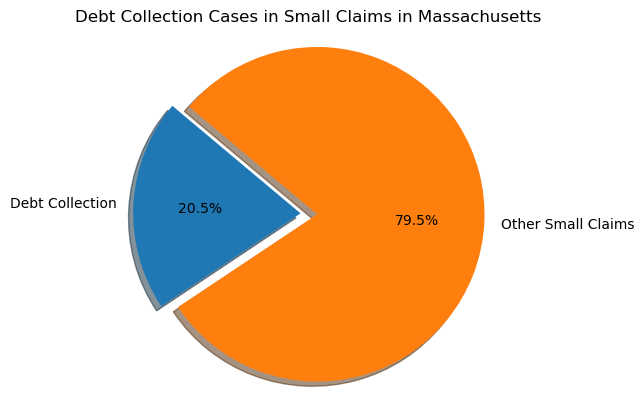

In [10]:
labels = 'Debt Collection', 'Other Small Claims'
sizes = [n_debt_collection_cases, n_small_claims_cases - n_debt_collection_cases]
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Debt Collection Cases in Small Claims in Massachusetts')
plt.show()


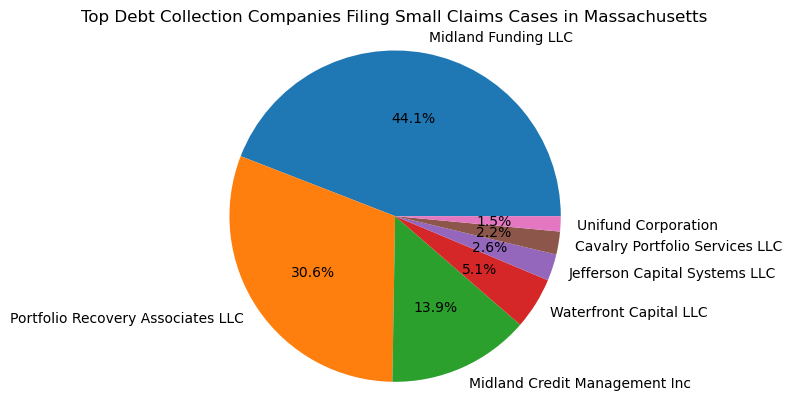

In [13]:
fig, ax = plt.subplots()
casesDC = cases.dropna()
casesDC = casesDC[casesDC['Debt Collector'].map(casesDC['Debt Collector'].value_counts()) > 3000]
casesDC['Debt Collector'] = casesDC['Debt Collector'].str.title()
casesDC['Debt Collector'] = casesDC['Debt Collector'].str.replace('Llc', 'LLC')
ax.pie(casesDC['Debt Collector'].value_counts(), labels = casesDC['Debt Collector'].value_counts().index, autopct='%1.1f%%')
ax.axis('equal')
plt.title('Top Debt Collection Companies Filing Small Claims Cases in Massachusetts')
plt.show()

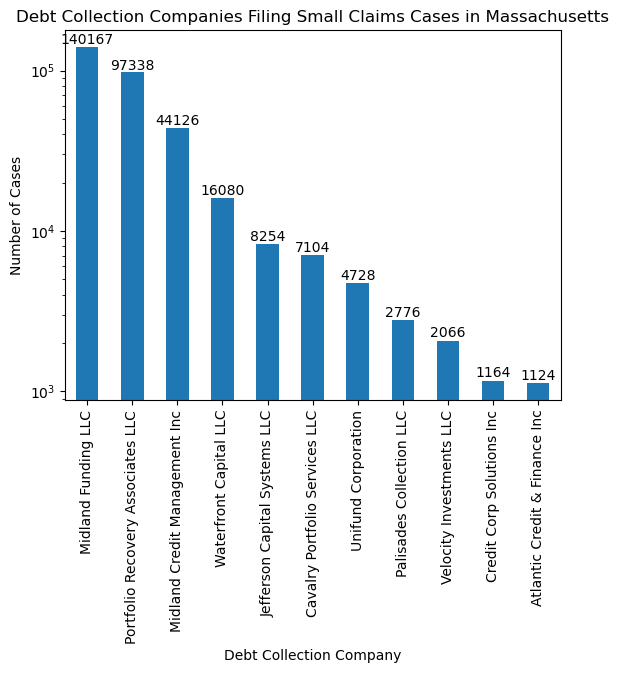

In [37]:
fig, ax = plt.subplots()
# set fig size
# fig.set_size_inches(10, 10)
casesDC = cases.dropna()
casesDC = casesDC[casesDC['Debt Collector'].map(casesDC['Debt Collector'].value_counts()) > 1000]
casesDC['Debt Collector'] = casesDC['Debt Collector'].str.title()
casesDC['Debt Collector'] = casesDC['Debt Collector'].str.replace('Llc', 'LLC')
casesDC['Debt Collector'].value_counts().plot(kind='bar', logy = True)
for i, v in enumerate(casesDC['Debt Collector'].value_counts()):
    ax.text(i, v + 10, str(v), ha = 'center', va = 'bottom')
plt.xticks(rotation = 90)
plt.xlabel('Debt Collection Company')
plt.title('Debt Collection Companies Filing Small Claims Cases in Massachusetts')
plt.ylabel('Number of Cases')
plt.show()

In [18]:
# closing connection to MySQL server
cursor.close() 
cnx.close()